In [1]:
%load_ext autoreload
%autoreload 2
import subprocess
from google.cloud import storage
import os
import PIL
import terra
import pandas as pd
import numpy as np
import meerkat as mk
import torchxrayvision as xrv
from domino.data.mimic import build_dp, mimic_transform

In [3]:
dp = build_dp(
    dataset_dir="/home/common/datasets/mimic", 
    gcp_project="hai-gcp-fine-grained"
)

task: build_dp, run_id=1056


In [18]:
dp = build_dp.out(963)

In [16]:
from skimage.io import imread
from domino.vision import score
import torch
from torchvision.transforms import Compose, Lambda, Resize
from torchxrayvision.datasets import XRayCenterCrop, XRayResizer, normalize

valid_dp = dp.lz[(dp["split"].data == "validate")]

def xrv_mimic_transform(img: PIL.Image.Image):
    transform = Compose(
        [
            Lambda(lambda x: normalize(np.array(x), 255)[None, :, :]),
            XRayCenterCrop(),
            XRayResizer(512),
            Lambda(lambda x: torch.tensor(x).float()),
        ]
    )
    return transform(img)
valid_dp["input"].transform = xrv_mimic_transform
valid_dp["input"].loader = imread

model = xrv.models.DenseNet(weights="densenet121-res224-mimic_nb") # MIMIC-CXR (MIT)
score_dp = score(
    model,
    dp=valid_dp,
    batch_size=64
)

100%|██████████| 8/8 [00:20<00:00,  2.58s/it]


In [17]:
class_to_idx = {
    label: idx for idx, label in 
    enumerate(xrv.models.model_urls["chex"]["labels"])
}
from sklearn.metrics import roc_auc_score
for i in range(score_dp["output"].shape[-1]):
    score = roc_auc_score(
        score_dp["Pneumothorax"].data, 
        score_dp["output"].probabilities().data[:, i]
    )
    print(score)

0.4794184104528932
0.5339096833349706
0.5230048793267184
0.6527000032747159
0.3969283164685463
0.5230048793267184
0.5230048793267184
0.4932377116285162
0.49880472868978615
0.5230048793267184
0.41919638471362614
0.5230048793267184
0.5230048793267184
0.5230048793267184
0.536529456069686
0.5914791891803386
0.4788289615875822
0.5083341520123129


In [15]:
from torchxrayvision.datasets import normalize, XRayCenterCrop, XRayResizer
from torchvision.transforms import Lambda, Compose, Resize
import torch

dp["input"].transform = mimic_transform


def test(img):
    from torchxrayvision.datasets import normalize, XRayCenterCrop, XRayResizer
    transform = Resize([224, 224])
    img = transform(img)
    transform = Lambda(lambda x: normalize(np.array(x), 255)[None, :, :])
    img = transform(img)
    transform = XRayCenterCrop()
    img = transform(img)
    transform = Lambda(lambda x: torch.tensor(x).expand(3, -1, -1))
    img = transform(img)

%lprun -f test test(dp["img"][0])

Timer unit: 1e-06 s

Total time: 0.048163 s
File: <ipython-input-15-327343a22b3f>
Function: test at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           def test(img):
     7         1          7.0      7.0      0.0      from torchxrayvision.datasets import normalize, XRayCenterCrop, XRayResizer
     8         1        138.0    138.0      0.3      transform = Resize([224, 224])
     9         1      41494.0  41494.0     86.2      img = transform(img)
    10         1         12.0     12.0      0.0      transform = Lambda(lambda x: normalize(np.array(x), 255)[None, :, :])
    11         1        343.0    343.0      0.7      img = transform(img)
    12         1          3.0      3.0      0.0      transform = XRayCenterCrop()
    13         1         94.0     94.0      0.2      img = transform(img)
    14         1          5.0      5.0      0.0      transform = Lambda(lambda x: torch.tensor(x).expand(3, -1, -1))
    15  

In [28]:
dp["input"].transform = mimic_transform

col = dp["input"]

%lprun -f mimic_transform col[0:4]

Timer unit: 1e-06 s

Total time: 0.125755 s
File: /home/sabri/code/domino/domino/data/mimic.py
Function: mimic_transform at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                           def mimic_transform(img: PIL.Image.Image):
    13         8         17.0      2.1      0.0      transform = Compose(
    14         4          2.0      0.5      0.0          [
    15         4        426.0    106.5      0.3              Resize(224),
    16         4         35.0      8.8      0.0              Lambda(lambda x: normalize(np.array(x), 255)[None, :, :]),
    17         4          7.0      1.8      0.0              XRayCenterCrop(),
    18         4          8.0      2.0      0.0              Lambda(lambda x: torch.tensor(x).expand(3, -1, -1))
    19                                                   ]
    20                                               )
    21         4     125260.0  31315.0     99.6      return transform(img)

In [4]:
dp["input"].transform = lambda x: x
dp["input"].map(lambda x: 0, num_workers=6, pbar=True)

  1%|          | 2125/243334 [00:19<36:06, 111.33it/s]


KeyboardInterrupt: 

In [35]:
from PIL import Image
import time

out = Image.open("/home/common/datasets/mimic/files/p10/p10000935/s51178377/9b314ad7-fbcb0422-6db62dfc-732858d0-a5527d8b.jpg")

In [13]:
import torch
x = torch.zeros([1,5,5])
x.expand(3, 5, 5).shape

torch.Size([3, 5, 5])

In [10]:
dataset_dir = "/home/common/datasets/mimic"
gcp_project = "hai-gcp-fine-grained"
storage_client = storage.Client(project=gcp_project)
bucket = storage_client.bucket(
    "mimic-cxr-jpg-2.0.0.physionet.org", user_project=gcp_project
)
filepath = os.path.join(dataset_dir, "mimic-cxr-2.0.0-split.csv.gz")
bucket.blob("mimic-cxr-2.0.0-split.csv.gz").download_to_filename(filepath)
subprocess.run(["gunzip", filepath])

dp.merge(
    mk.DataPanel.from_csv(os.path.join(dataset_dir, "mimic-cxr-2.0.0-split.csv"))[
        ["split", "dicom_id"]
    ],
    how="left",
    on="dicom_id",
)


,dicom_id (NumpyArrayColumn),subject_id_x (NumpyArrayColumn),study_id (NumpyArrayColumn),path (NumpyArrayColumn),subject_id_1 (NumpyArrayColumn),study_id_1 (NumpyArrayColumn),path_1 (NumpyArrayColumn),subject_id_2 (NumpyArrayColumn),study_id_2 (NumpyArrayColumn),Atelectasis (NumpyArrayColumn),...,marital_status (NumpyArrayColumn),ethnicity (NumpyArrayColumn),edregtime (NumpyArrayColumn),edouttime (NumpyArrayColumn),hospital_expire_flag (NumpyArrayColumn),jpg_path (NumpyArrayColumn),img (GCSImageColumn),input (GCSImageColumn),split (NumpyArrayColumn),index (ListColumn)
0,9b314ad7-fbcb0422-6db62dfc-732858d0-a5527d8b,10000935,51178377,files/p10/p10000935/s51178377/9b314ad7-fbcb042...,10000935,51178377,files/p10/p10000935/s51178377.txt,10000935.0,51178377.0,0,...,SINGLE,BLACK/AFRICAN AMERICAN,2187-08-23 14:37:00,2187-08-23 22:46:00,0.0,files/p10/p10000935/s51178377/9b314ad7-fbcb042...,ImagePathCell(files/p10/p10000935/s51178377/9b...,ImagePathCell(files/p10/p10000935/s51178377/9b...,train,'0'
1,3b8b1b7d-054490d5-385641e7-ff43d2c8-9505f058,10001176,54684191,files/p10/p10001176/s54684191/3b8b1b7d-054490d...,10001176,54684191,files/p10/p10001176/s54684191.txt,10001176.0,54684191.0,0,...,MARRIED,WHITE,2186-11-28 21:34:00,2186-11-29 05:01:00,0.0,files/p10/p10001176/s54684191/3b8b1b7d-054490d...,ImagePathCell(files/p10/p10001176/s54684191/3b...,ImagePathCell(files/p10/p10001176/s54684191/3b...,train,'1'
2,ed9c0dfc-ea25b576-0f8cc069-df4cdf14-0cd60eb7,10001176,54684191,files/p10/p10001176/s54684191/ed9c0dfc-ea25b57...,10001176,54684191,files/p10/p10001176/s54684191.txt,10001176.0,54684191.0,0,...,MARRIED,WHITE,2186-11-28 21:34:00,2186-11-29 05:01:00,0.0,files/p10/p10001176/s54684191/ed9c0dfc-ea25b57...,ImagePathCell(files/p10/p10001176/s54684191/ed...,ImagePathCell(files/p10/p10001176/s54684191/ed...,train,'2'
3,d9db838d-4612fd1e-e45b40a9-3ea30033-26efd8e4,10001401,55350604,files/p10/p10001401/s55350604/d9db838d-4612fd1...,10001401,55350604,files/p10/p10001401/s55350604.txt,10001401.0,55350604.0,0,...,MARRIED,WHITE,2131-07-30 12:47:00,2131-07-31 01:35:00,0.0,files/p10/p10001401/s55350604/d9db838d-4612fd1...,ImagePathCell(files/p10/p10001401/s55350604/d9...,ImagePathCell(files/p10/p10001401/s55350604/d9...,train,'3'
4,52d6c812-26dfed36-97e26b11-1fa88177-e8b8b150,10001884,53880659,files/p10/p10001884/s53880659/52d6c812-26dfed3...,10001884,53880659,files/p10/p10001884/s53880659.txt,10001884.0,53880659.0,0,...,MARRIED,BLACK/AFRICAN AMERICAN,2130-10-08 12:27:00,2130-10-08 21:24:00,0.0,files/p10/p10001884/s53880659/52d6c812-26dfed3...,ImagePathCell(files/p10/p10001884/s53880659/52...,ImagePathCell(files/p10/p10001884/s53880659/52...,train,'4'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243329,c09014f4-a597350e-18af189b-348221e2-316c74ef,19983508,57052056,files/p19/p19983508/s57052056/c09014f4-a597350...,19983508,57052056,files/p19/p19983508/s57052056.txt,19983508.0,57052056.0,0,...,NaN,NaN,NaT,NaT,NaN,files/p19/p19983508/s57052056/c09014f4-a597350...,ImagePathCell(files/p19/p19983508/s57052056/c0...,ImagePathCell(files/p19/p19983508/s57052056/c0...,train,'243329'
243330,ac0b3fbd-40e0bf99-8c7bda63-98b60f34-2f8d84bf,19984491,55712435,files/p19/p19984491/s55712435/ac0b3fbd-40e0bf9...,19984491,55712435,files/p19/p19984491/s55712435.txt,19984491.0,55712435.0,1,...,MARRIED,WHITE,2163-03-02 12:21:00,2163-03-02 17:13:00,0.0,files/p19/p19984491/s55712435/ac0b3fbd-40e0bf9...,ImagePathCell(files/p19/p19984491/s55712435/ac...,ImagePathCell(files/p19/p19984491/s55712435/ac...,train,'243330'
243331,4011e4c8-32695a5c-3bf7cddd-f1602228-d0d391b5,19991743,54080659,files/p19/p19991743/s54080659/4011e4c8-32695a5...,19991743,54080659,files/p19/p19991743/s54080659.txt,19991743.0,54080659.0,0,...,NaN,NaN,NaT,NaT,NaN,files/p19/p19991743/s54080659/4011e4c8-32695a5...,ImagePathCell(files/p19/p19991743/s54080659/40...,ImagePathCell(files/p19/p19991743/s54080659/40...,train,'243331'
243332,11f33f3e-7fdf7618-ebcbb376-cff190da-b2f

In [13]:
from domino.data.mimic import mimic_transform

mimic_transform(dp["img"][0])

tensor([[[ -763.2016,  -883.5898,  -884.0353,  ...,  -884.0353,
           -883.5898,  -763.2016],
         [ -883.5898, -1022.9683, -1023.4840,  ..., -1023.4840,
          -1022.9683,  -883.5898],
         [ -884.0353, -1023.4840, -1024.0000,  ..., -1024.0000,
          -1023.4840,  -884.0353],
         ...,
         [ -884.0353, -1023.4840, -1024.0000,  ..., -1024.0000,
          -1023.4840,  -884.0353],
         [ -883.5898, -1022.9683, -1023.4840,  ..., -1023.4840,
          -1022.9683,  -883.5898],
         [ -763.2016,  -883.5898,  -884.0353,  ...,  -884.0353,
           -883.5898,  -763.2016]]])

In [24]:
dataset_dir = "/home/common/datasets/mimic-cxr"

In [25]:

storage_client = storage.Client(project="hai-gcp-fine-grained")
bucket = storage_client.bucket(
    "mimic-cxr-2.0.0.physionet.org", 
    user_project="hai-gcp-fine-grained"
)


[2021-07-02 19:26:48,086][WARNING][google.auth._default:475] :: No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


In [26]:
blob_name = "mimic-cxr-reports.zip"
filepath = os.path.join(dataset_dir, blob_name)
bucket.blob(blob_name).download_to_filename(filepath)

FileNotFoundError: [Errno 2] No such file or directory: '/home/common/datasets/mimic-cxr/mimic-cxr-reports.zip'

In [ ]:
dataset_dir = "/home/common/datasets/mimic-cxr"
for blob_name in  ["cxr-record-list.csv.gz", "cxr-study-list.csv.gz"]:
    filepath = os.path.join(dataset_dir, blob_name)
    bucket.blob(blob_name).download_to_filename(filepath)
    subprocess.run(["gunzip", filepath])

# subprocess.run(["unzip", filepath])

In [ ]:
# prepare jpg version

storage_client = storage.Client(project="hai-gcp-fine-grained")
bucket = storage_client.bucket(
    "mimic-cxr-jpg-2.0.0.physionet.org", 
    user_project="hai-gcp-fine-grained"
)

for blob_name in [
    "mimic-cxr-2.0.0-chexpert.csv.gz",
    "mimic-cxr-2.0.0-metadata.csv.gz",
    "mimic-cxr-2.0.0-negbio.csv.gz",
    "mimic-cxr-2.0.0-split.csv.gz",
]:
    filepath = os.path.join(dataset_dir, blob_name)
    bucket.blob(blob_name).download_to_filename(filepath)
    subprocess.run(["gunzip", filepath])

[2021-07-01 02:12:10,455][WARNING][google.auth._default:475] :: No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


In [ ]:
study_dp = mk.DataPanel.from_csv(
    os.path.join(dataset_dir, "cxr-study-list.csv")
)
def loader(path: str):
    with open(os.path.join(dataset_dir, path), "r") as f:
        return f.read()

col = mk.ImageColumn.from_filepaths(study_dp["path"], loader=loader)
study_dp["report"] = col

In [ ]:
study_dp["report"][400]

'                                 FINAL REPORT\n HISTORY:  Seizures, question interval change.\n \n CHEST, SINGLE AP PORTABLE VIEW.\n \n An ET tube is present, tip approximately 3.7 cm above the carina.  A right IJ\n central line is present, tip near SVC/RA junction.  An NG tube is present, tip\n extending beneath the diaphragm, off the film.  \n \n There is probable cardiomegaly, though the cardiomediastinal silhouette is\n unchanged.  There is possible mild vascular plethora, but no overt CHF.  There\n is minimal atelectasis at the left lung base.  Again seen is density seen\n along the right sixth rib laterally, ? callus about a rib fracture.\n \n IMPRESSION:  Essentially unchanged compared with ___ at 9:19 a.m.\n'

In [ ]:
dp = mk.DataPanel.from_csv(
    os.path.join(dataset_dir, "cxr-record-list.csv")
)

paths = pd.Series(dp["path"].data)
dp["jpg_path"] = paths.str.split(".").str[0] + ".jpg"

<bound method StringMethods.split of <pandas.core.strings.accessor.StringMethods object at 0x7f1a705e78e0>>

In [ ]:
import io
from pydicom import dcmread
from dosma import DicomReader
from PIL import Image


class GCSLoader:
    def __init__(self, bucket_name: str, project: str, loader: callable = None):
        storage_client = storage.Client(project=project)
        self.bucket = storage_client.bucket(bucket_name, user_project=project)
        self.loader = (lambda x: x) if loader is None else loader

    def __call__(self, blob_name):
        return self.loader(
            io.BytesIO(self.bucket.blob(str(blob_name)).download_as_bytes())
        )

loader = GCSLoader(
    bucket_name="mimic-cxr-jpg-2.0.0.physionet.org",
    project="hai-gcp-fine-grained",
    #loader=dcmread,
    loader=Image.open
)

[2021-07-01 16:51:12,136][WARNING][google.auth._default:475] :: No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


In [ ]:
col = mk.ImageColumn.from_filepaths(dp["jpg_path"], loader=loader)

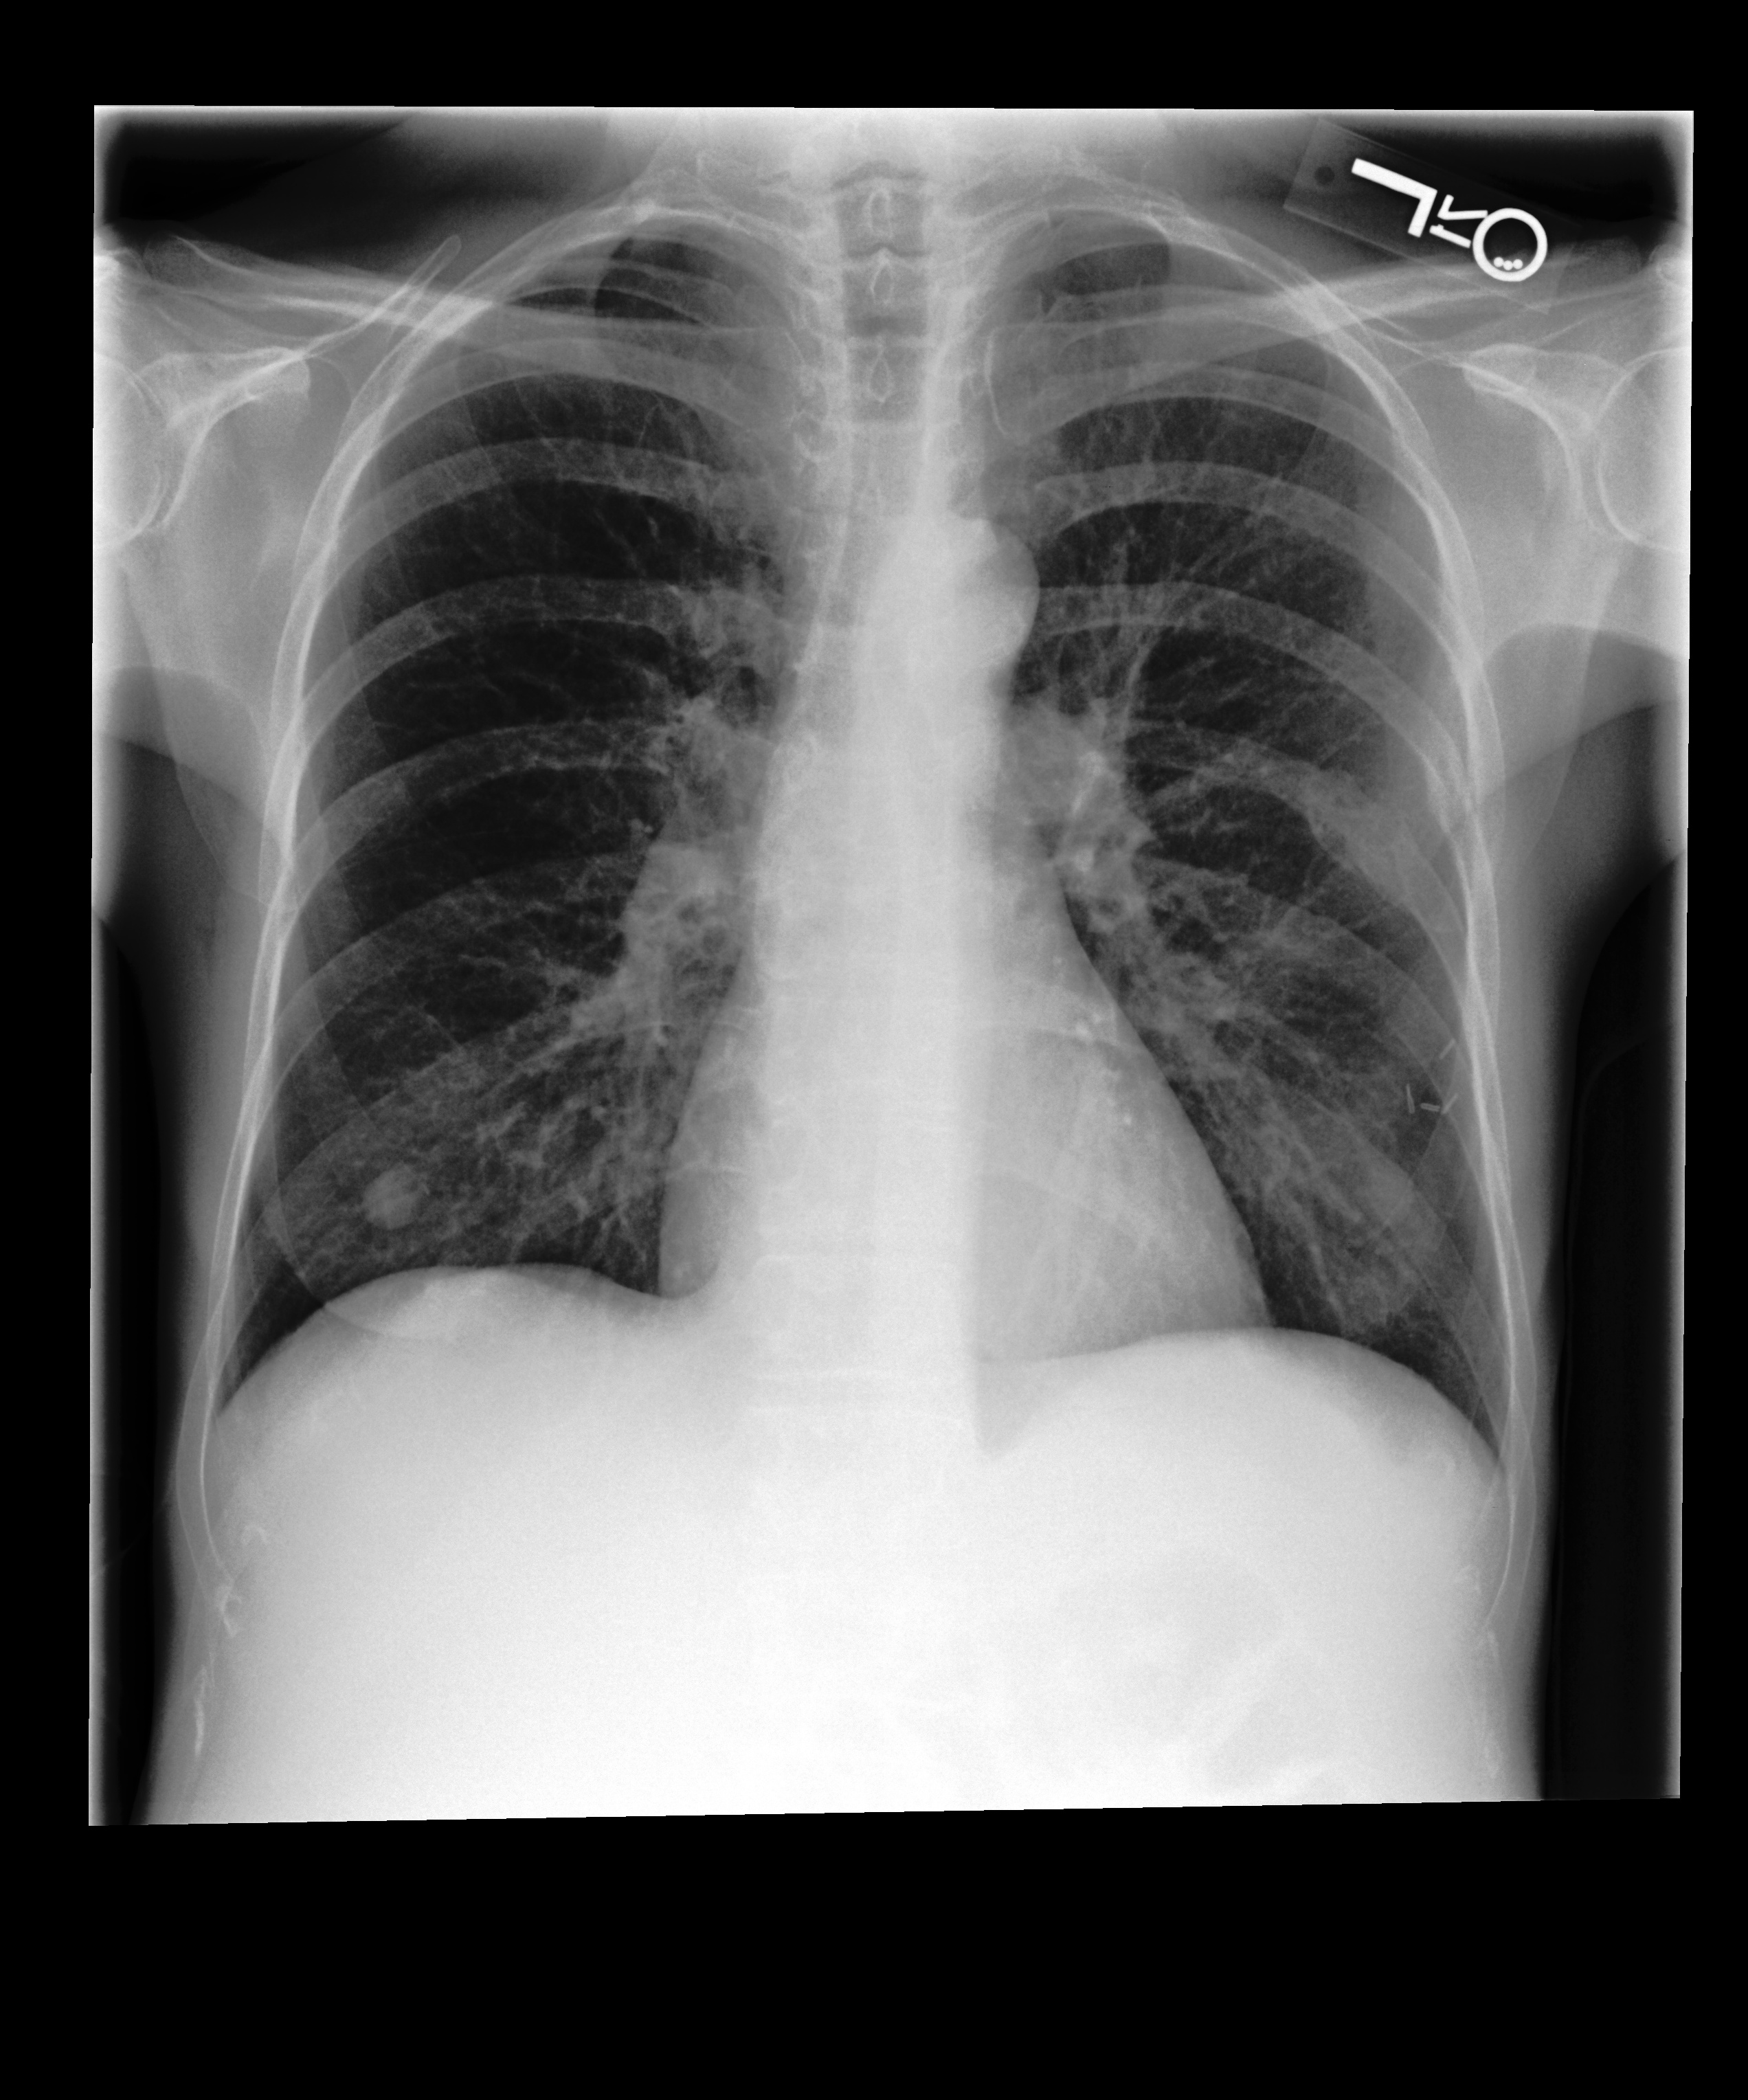

In [ ]:
col[0]

In [ ]:
def get_metadata(x):
    metadata = {}
    for k, v in x.items():
        if (k.group in [0x0018, 0x0008, 0x0002, 0x0020] and hasattr(v, "name")):
            metadata[v.name.lower().replace(" ", "_")] = v.value
    return metadata

out = col.lz[:10].map(get_metadata, pbar=True)

100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


In [ ]:
metadata = {}
for k, v in col[0].items():
    if k.group in [0x0018, 0x0008, 0x0002, 0x0020]:
        metadata[v.name.lower().replace(" ", "_")] = v.value

AttributeError: 'RawDataElement' object has no attribute 'name'

In [ ]:
out = col[0]

In [ ]:
import meerkat as mk
from dosma import DicomReader
from meerkat.contrib.siim_cxr import cxr_transform, cxr_transform_pil

loader = DicomReader(group_by=None, default_ornt=("SI", "AP"))
cell = mk.MedicalVolumeCell(
    "/root/test.dcm", loader=loader, transform=cxr_transform_pil
)
blob = bucket.blob("files/p10/p10000032/s50414267/174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962.dcm")

In [ ]:
out = loader("/home/sabri/test.dcm")

In [ ]:
from pydicom import dcmread
dcmread("/home/sabri/test.dcm")

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.30925724177439423411425919179398157560
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 2.25.55362949469033348352269585565668676650
(0002, 0013) Implementation Version Name         SH: 'MIMIC-CXR v2.0.0'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: Digital X-Ray Image Storage - For Presentation
(0008, 0018) SOP Instance UID                    UI: 2.25.309257241774394234114259191793981

In [11]:
from meerkat.contrib.mimic import query_mimic

In [ ]:
df = query_mimic(
    query_str="""
        SELECT *
        FROM `physionet-data.mimic_core.admissions` cxr_records
    """,
    gcp_project="hai-gcp-fine-grained"
)
df

[2021-07-02 18:49:12,119][WARNING][google.auth._default:475] :: No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,19940860,24902106,2130-12-31 09:19:00,2131-01-22 13:33:00,NaT,URGENT,None,HOME HEALTH CARE,Other,ENGLISH,None,WHITE,NaT,NaT,0
1,17615674,27014468,2142-11-29 21:16:00,2143-01-13 12:28:00,NaT,URGENT,None,HOME,Medicaid,ENGLISH,None,BLACK/AFRICAN AMERICAN,NaT,NaT,0
2,11786836,29132076,2117-05-04 19:28:00,2117-08-17 17:28:00,NaT,URGENT,None,HOME HEALTH CARE,Other,ENGLISH,None,BLACK/AFRICAN AMERICAN,NaT,NaT,0
3,19858751,23670116,2164-08-24 03:26:00,2164-09-05 12:10:00,NaT,URGENT,None,HOME HEALTH CARE,Other,ENGLISH,None,UNKNOWN,NaT,NaT,0
4,18186739,29454835,2121-07-28 15:25:00,2121-08-23 16:26:00,NaT,URGENT,None,HOME,Other,ENGLISH,None,OTHER,NaT,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523735,16482959,24980934,2112-11-07 11:15:00,2112-11-12 15:45:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME HEALTH CARE,Medicare,?,DIVORCED,BLACK/AFRICAN AMERICAN,NaT,NaT,0
523736,14978114,21126907,2191-07-27 00:00:00,2191-07-31 13:20:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,DIVORCED,WHITE,NaT,NaT,0
523737,17561060,28949982,2149-02-09 09:30:00,2149-02-10 16:45:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME HEALTH CARE,Medicare,ENGLISH,DIVORCED,WHITE,NaT,NaT,0
523738,17333919,22819488,2140-06-20 10:00:00,2140-06-21 12:24:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME,Medicare,?,DIVORCED,BLACK/AFRICAN AMERICAN,NaT,NaT,0


<AxesSubplot:xlabel='count', ylabel='admission_location'>

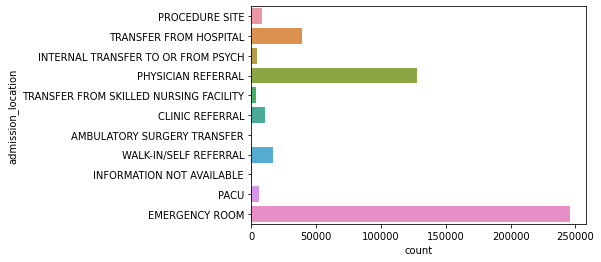

In [ ]:
import seaborn as sns
sns.countplot(y=df["admission_location"])

In [10]:

df.hadm_id.isna().mean()

0.34001219803240434

In [5]:
from meerkat.contrib.mimic import build_mimic_dp
df = build_mimic_dp(
    dataset_dir="", gcp_project="hai-gcp-fine-grained"
)
df

,subject_id_x,study_id,dicom_id,path,subject_id_1,study_id_1,path_1,subject_id_2,study_id_2,Atelectasis,...,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,10000935,51178377,9b314ad7-fbcb0422-6db62dfc-732858d0-a5527d8b,files/p10/p10000935/s51178377/9b314ad7-fbcb042...,10000935,51178377,files/p10/p10000935/s51178377.txt,10000935.0,51178377.0,NaN,...,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN,2187-08-23 14:37:00,2187-08-23 22:46:00,0.0
1,10001176,54684191,3b8b1b7d-054490d5-385641e7-ff43d2c8-9505f058,files/p10/p10001176/s54684191/3b8b1b7d-054490d...,10001176,54684191,files/p10/p10001176/s54684191.txt,10001176.0,54684191.0,NaN,...,EU OBSERVATION,EMERGENCY ROOM,None,Medicare,ENGLISH,MARRIED,WHITE,2186-11-28 21:34:00,2186-11-29 05:01:00,0.0
2,10001176,54684191,ed9c0dfc-ea25b576-0f8cc069-df4cdf14-0cd60eb7,files/p10/p10001176/s54684191/ed9c0dfc-ea25b57...,10001176,54684191,files/p10/p10001176/s54684191.txt,10001176.0,54684191.0,NaN,...,EU OBSERVATION,EMERGENCY ROOM,None,Medicare,ENGLISH,MARRIED,WHITE,2186-11-28 21:34:00,2186-11-29 05:01:00,0.0
3,10001401,55350604,0fb4f936-4101f4fa-702d001f-155c63e8-d0d6b2b6,files/p10/p10001401/s55350604/0fb4f936-4101f4f...,10001401,55350604,files/p10/p10001401/s55350604.txt,10001401.0,55350604.0,NaN,...,OBSERVATION ADMIT,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,2131-07-30 12:47:00,2131-07-31 01:35:00,0.0
4,10001401,55350604,d9db838d-4612fd1e-e45b40a9-3ea30033-26efd8e4,files/p10/p10001401/s55350604/d9db838d-4612fd1...,10001401,55350604,files/p10/p10001401/s55350604.txt,10001401.0,55350604.0,NaN,...,OBSERVATION ADMIT,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,2131-07-30 12:47:00,2131-07-31 01:35:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377105,19983508,57052056,c09014f4-a597350e-18af189b-348221e2-316c74ef,files/p19/p19983508/s57052056/c09014f4-a597350...,19983508,57052056,files/p19/p19983508/s57052056.txt,19983508.0,57052056.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
377106,19984491,55712435,ac0b3fbd-40e0bf99-8c7bda63-98b60f34-2f8d84bf,files/p19/p19984491/s55712435/ac0b3fbd-40e0bf9...,19984491,55712435,files/p19/p19984491/s55712435.txt,19984491.0,55712435.0,1.0,...,OBSERVATION ADMIT,EMERGENCY ROOM,REHAB,Medicare,ENGLISH,MARRIED,WHITE,2163-03-02 12:21:00,2163-03-02 17:13:00,0.0
377107,19991743,54080659,4011e4c8-32695a5c-3bf7cddd-f1602228-d0d391b5,files/p19/p19991743/s54080659/4011e4c8-32695a5...,19991743,54080659,files/p19/p19991743/s54080659.txt,19991743.0,54080659.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
377108,19992875,50634814,11f33f3e-7fdf7618-ebcbb376-cff190da-b2ff9081,files/p19/p19992875/s50634814/11f33f3e-7fdf761...,19992875,50634814,files/p19/p19992875/s50634814.txt,19992875.0,50634814.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN


In [33]:
subject_id = df.iloc[4]["subject_id"]
df.iloc[4]["StudyDate"]

'21590605'

In [12]:
admit_df = query_mimic(
    query_str="""
        SELECT *
        FROM `physionet-data.mimic_cxr.dicom_metadata_string`
    """,
    gcp_project="hai-gcp-fine-grained"
)

In [31]:
admit_df["DetectorElementPhysicalSize"].unique()

array(["['139', '139']", "['0.139', '0.139']", None,
       "['0.200000', '0.200000']", "['0.2', '0.2']"], dtype=object)

In [19]:
admit_df.nunique().to_dict()

{'dicom': 377110,
 'SpecificCharacterSet': 1,
 'ImageType': 10,
 'SOPClassUID': 3,
 'SOPInstanceUID': 377110,
 'StudyDate': 34846,
 'SeriesDate': 34848,
 'AcquisitionDate': 34848,
 'ContentDate': 34848,
 'StudyTime': 218816,
 'SeriesTime': 320619,
 'AcquisitionTime': 341792,
 'ContentTime': 344170,
 'AccessionNumber': 227835,
 'Modality': 2,
 'PresentationIntentType': 2,
 'Manufacturer': 0,
 'ReferringPhysicianName': 0,
 'ProcedureCodeSequence': 2,
 'AnatomicRegionSequence': 2,
 'PatientName': 0,
 'PatientID': 65379,
 'PatientBirthDate': 0,
 'PatientSex': 0,
 'PatientIdentityRemoved': 1,
 'DeidentificationMethod': 1,
 'DeidentificationMethodCodeSequence': 1,
 'BodyPartExamined': 5,
 'KVP': 93,
 'DistanceSourceToDetector': 853,
 'TableType': 2,
 'FieldOfViewShape': 1,
 'FieldOfViewDimensions': 8356,
 'ExposureTime': 501,
 'XRayTubeCurrent': 366,
 'Exposure': 259,
 'ExposureInuAs': 16376,
 'RectificationType': 1,
 'FilterType': 3,
 'ImagerPixelSpacing': 505,
 'Grid': 7,
 'AnodeTargetMate

In [53]:
d = df[["subject_id", "StudyDate", "study_id"]].merge(admit_df, on="subject_id")

In [54]:
study_date = pd.to_datetime(d["StudyDate"])
study_subject = d[(study_date >= d["admittime"].dt.date) & (study_date <= d["dischtime"].dt.date)]

In [56]:
out = df.merge(study_subject.drop_duplicates(subset="study_id"), how="left", on="study_id")

In [57]:
out

,subject_id_x,study_id,dicom_id,path,subject_id_1,study_id_1,path_1,subject_id_2,study_id_2,Atelectasis,...,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,10035631,57929979,292935dd-c510033a-e1cdbf6b-4c0f3c7e-39b98d68,files/p10/p10035631/s57929979/292935dd-c510033...,10035631,57929979,files/p10/p10035631/s57929979.txt,10035631.0,57929979.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
1,10052277,55162593,f34211ac-22e8030e-69f7e710-2457d891-8851dd15,files/p10/p10052277/s55162593/f34211ac-22e8030...,10052277,55162593,files/p10/p10052277/s55162593.txt,10052277.0,55162593.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
2,10071403,55130499,4c246dcb-e72e2e6c-94b396f9-9c154f3b-623fa0b7,files/p10/p10071403/s55130499/4c246dcb-e72e2e6...,10071403,55130499,files/p10/p10071403/s55130499.txt,10071403.0,55130499.0,NaN,...,URGENT,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,WHITE,NaT,NaT,0.0
3,10087129,55233929,a21811ce-aaa46366-1924fff2-6d47f677-695101e9,files/p10/p10087129/s55233929/a21811ce-aaa4636...,10087129,55233929,files/p10/p10087129/s55233929.txt,10087129.0,55233929.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
4,10198310,52908323,ff7d1ad3-f6e1cd09-288ac039-d69f45d4-8ebbacf3,files/p10/p10198310/s52908323/ff7d1ad3-f6e1cd0...,10198310,52908323,files/p10/p10198310/s52908323.txt,10198310.0,52908323.0,0.0,...,OBSERVATION ADMIT,PHYSICIAN REFERRAL,HOME,Other,ENGLISH,SINGLE,WHITE,NaT,NaT,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377105,17503124,50477344,28fc1a98-a3e3bae9-607c5602-e138ca27-30126424,files/p17/p17503124/s50477344/28fc1a98-a3e3bae...,17503124,50477344,files/p17/p17503124/s50477344.txt,17503124.0,50477344.0,1.0,...,EW EMER.,PROCEDURE SITE,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,WHITE,NaT,NaT,0.0
377106,17509032,59687769,a0ee36a9-5a2b8b30-7c1cd9b5-41e64938-5880a380,files/p17/p17509032/s59687769/a0ee36a9-5a2b8b3...,17509032,59687769,files/p17/p17509032/s59687769.txt,17509032.0,59687769.0,NaN,...,URGENT,TRANSFER FROM HOSPITAL,HOME,Medicare,ENGLISH,MARRIED,HISPANIC/LATINO,NaT,NaT,0.0
377107,18608309,59374619,269e758f-d41b4d12-36a21b46-64ab3cfb-0825f7f8,files/p18/p18608309/s59374619/269e758f-d41b4d1...,18608309,59374619,files/p18/p18608309/s59374619.txt,18608309.0,59374619.0,NaN,...,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,WHITE,2190-04-28 17:21:00,2190-04-28 20:59:00,0.0
377108,19512875,53045426,1345b9df-a42585f3-52f4f562-e654e8e8-26d1cb8b,files/p19/p19512875/s53045426/1345b9df-a42585f...,19512875,53045426,files/p19/p19512875/s53045426.txt,19512875.0,53045426.0,1.0,...,EW EMER.,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,WHITE,2142-07-19 00:48:00,2142-07-19 05:00:00,0.0


In [20]:
transfer_df = query_mimic(
    query_str="""
        SELECT *
        FROM `physionet-data.mimic_core.transfers` cxr_records
    """,
    gcp_project="hai-gcp-fine-grained"
)

[2021-07-02 19:22:06,932][WARNING][google.auth._default:475] :: No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


In [21]:
transfer_df[transfer_df["subject_id"] == 10071403]

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
134487,10071403,23501159.0,30884011,ED,Emergency Department,2173-11-29 23:42:00,2173-11-30 12:08:24
425417,10071403,29009295.0,37201462,ED,Emergency Department,2173-12-29 16:08:00,2173-12-29 22:51:00
739123,10071403,23501159.0,38653479,admit,PACU,2173-11-30 12:08:24,2173-11-30 15:48:05
968608,10071403,29009295.0,39318387,admit,Hematology/Oncology,2173-12-29 22:51:00,2173-12-31 21:39:24
1176317,10071403,29057225.0,39745360,admit,Cardiac Vascular Intensive Care Unit (CVICU),2173-11-10 15:00:16,2173-11-15 22:16:51
1269300,10071403,23501159.0,32815697,transfer,Med/Surg,2173-11-30 16:49:01,2173-12-04 17:44:31
1273890,10071403,23501159.0,33977869,transfer,Med/Surg,2173-11-30 16:45:05,2173-11-30 16:49:01
1287370,10071403,23501159.0,39071979,transfer,Med/Surg,2173-11-30 15:48:05,2173-11-30 16:45:05
1314577,10071403,29057225.0,37087982,transfer,Medicine,2173-11-17 12:30:08,2173-11-19 20:22:40
1494750,10071403,29009295.0,30844261,transfer,Hematology/Oncology,2173-12-31 21:39:24,2174-01-05 00:14:45
